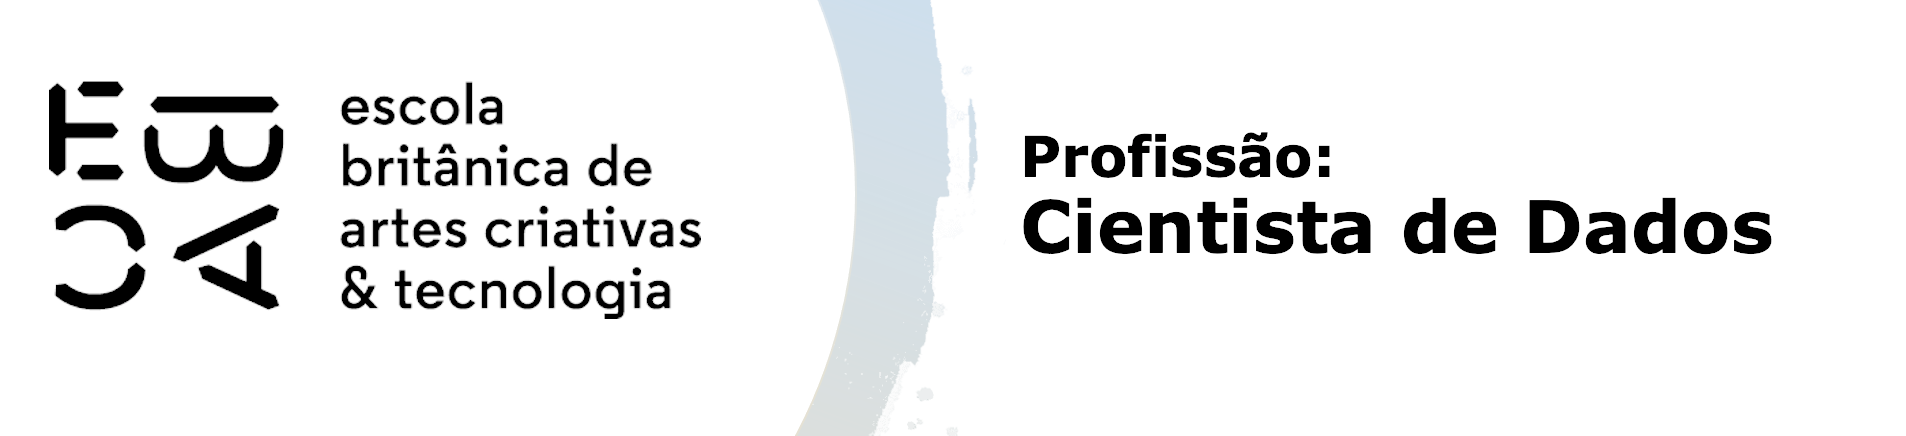

## Trabalhando com dados mistos

Precisamos de uma definição de distância que acomode dados qualitativos como:

- Sexo
- Raça do pinguim
- Tipo de cartão etc

## Distâncias

Podemos usar diversos tipos de distância para rodar o nosso algoritmo. Vamos comentar algumas que terão efeito prático sobre os nossos próximos passos:

- Distância euclidiana: a distância mais intuitiva e comum de se utilizar para variáveis quantitativas.
- Distância Manhattan: É a distância percorrida entre dois pontos quando só se anda na vertical ou na horizontal. Tem vantagens para se calcular, e é utilizada na distância de Gower.
- Distância dice: é uma medida de distância para dados qualitativos. É baseada na quantidade de características em comum entre duas observações.
- Distância de Gower: É popular para a realização de agrupamentos com variáveis binárias e contínuas na mesma tabela. Ela conjuga a distância de Dice para variáveis discretas e distância Manhattan para variáveis contínuas.

| | |
|:-:|:-:|
| Distância Euclidiana | Distância de Manhattan |
| <div><img src="attachment/5-image-3.png" width="300"/></div> | <div><img src="attachment/5-image-2.png" width="300"/></div> |
| Distância Dice | Distância de Gower |
| <div><img src="attachment/5-image-7.png" width="300"/></div> | <div><img src="attachment/5-image-6.png" width="300"/></div> |


# Tipos de dados misturados

Vamos fazer uma aplicação em uma base, misturando dados categorizados e dados numéricos utilizando a distância de Gower.

Os métodos hierárquicos podem ser executados tendo como input a matriz de distâncias, e é isso que vamos fazer. Antes de começar é importante planejar os passos a serem seguidos, então vamos fazer isso. Vamos executar os seguintes passos:

- Tratamento de dados:
    - Missing: decidir o que fazer com eles. Eliminar ou preencher?
    - Criar *dummies* para dados categorizados
    - Identificar variáveis *dummy*
- Calcular a matriz de distâncias com o método de Gower
- Executar o agrupamento hierárquico a partir dessa matriz
- Avaliar os agrupamentos

In [1]:
!pip install gower


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix
import pandas as pd
import seaborn as sns

import numpy as np

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

## Carregar os dados

In [3]:
pg = sns.load_dataset('penguins')

## Tratamento de dados

Aqui, precisamos decidir o que fazer com dados não preenchidos. 

- Os dados quantitativos não preenchidos tem uma resposta mais ou menos óbvia: removê-los. Digo isto porque há apenas dois registros com dados não preenchidos, e todas as variáveis quantitativas estão sem preenchimento para essas duas observações.

- Dados discretos não preenchidos: aqui já dá mais pra discutir o que fazer. Há mais registros sem o preenchimento de sexo. Talvez a determinação do sexo de um pinguim não seja trivial em determinadas situações. Podemos adotar duas posturas:
    - Eliminar os dados com valores faltantes: os prós são a velocidade e o pragmatismo, os contras são a eliminação de dados, e que podemos continuar com o mesmo problema se quisermos aplicar o modelo para indivíduos fora da amostra.
    - Preencher com o valor modal ou um valor aleatório: o ponto pró é o aproveitamento dos dados dos indivíduos com as demais variáveis preenchidas, o ponto contra é a introdução de ruído no modelo.
    - Preenchimento por modelo (ex: por random forest): pontos pró são aproveitamento das observações, introdução reduzida de ruído, ter um método para aplicação em outras amostras. Pontos contra: tempo de desenvolvimento e aumento da complexidade do modelo.

In [4]:
pg.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [5]:
variaveis = pg.columns.values[2:]
variaveis_cat = variaveis[-1]

In [6]:
pg2 = pd.get_dummies(pg[variaveis].dropna())
pg2.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_Female,sex_Male
0,39.1,18.7,181.0,3750.0,False,True
1,39.5,17.4,186.0,3800.0,True,False
2,40.3,18.0,195.0,3250.0,True,False
4,36.7,19.3,193.0,3450.0,True,False
5,39.3,20.6,190.0,3650.0,False,True


In [7]:
pg2.columns.values

array(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex_Female', 'sex_Male'], dtype=object)

In [8]:
vars_cat = [True if x in {'sex_Male', 'sex_Female'} else False for x in pg2.columns]

In [9]:
vars_cat

[False, False, False, False, True, True]

In [10]:
pg2.shape

(333, 6)

## Calculando as distâncias

A função ```gower_matrix``` calcula a matriz de distâncias utilizando a distância de Gower. Como já vimos, essa distância é a distância 'dice' para variáveis categorizadas e a distância 'Manhattan' para variáveis contínuas.

Como as variáveis categorizadas estão em formato de *dummy* (elas **tem** que estar como *dummy*), precisamos indicar para o algoritmo quais são as variáveis categorizadas. Vamos fazer isso no parâmetro ```cat_features```.

In [11]:
distancia_gower = gower_matrix(pg2, cat_features=vars_cat)

In [12]:
distancia_gower[:5, :5]

array([[0.        , 0.37799034, 0.41719112, 0.40757075, 0.06896389],
       [0.37799034, 0.        , 0.06763994, 0.09064583, 0.4162814 ],
       [0.41719112, 0.06763994, 0.        , 0.06252081, 0.42362407],
       [0.40757075, 0.09064583, 0.06252081, 0.        , 0.3926184 ],
       [0.06896389, 0.4162814 , 0.42362407, 0.3926184 , 0.        ]],
      dtype=float32)

Precisamos ajustar o formato da matriz de distâncias para alimentar o algoritmo com este objeto. Vamos fazer isso com a função ```squareform``` do numpy.

In [13]:
gdv = squareform(distancia_gower,force='tovector')

In [14]:
gdv.shape

(55278,)

## Treinando o agrupamento

Agora vamos usar a função ```linkage``` do scipy, indicando o método como *complete*, para rodar este algoritmo com a matriz de distâncias indicada. Em seguida, por uma questão de conveniência, vamos transformar o objeto com o modelo 'treinado' em um *data frame*.

In [15]:
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

,id1,id2,dist,n
0,31.0,101.0,0.005951,2.0
1,42.0,46.0,0.006061,2.0
2,220.0,304.0,0.007730,2.0
3,254.0,305.0,0.007730,2.0
4,260.0,295.0,0.008170,2.0


## Dendrograma

Uma outra forma de fazer o dendrograma é com a função ```dendrogram``` do scipy, que recebe a informação do próprio objeto do agrupamento.

Leaves = 333


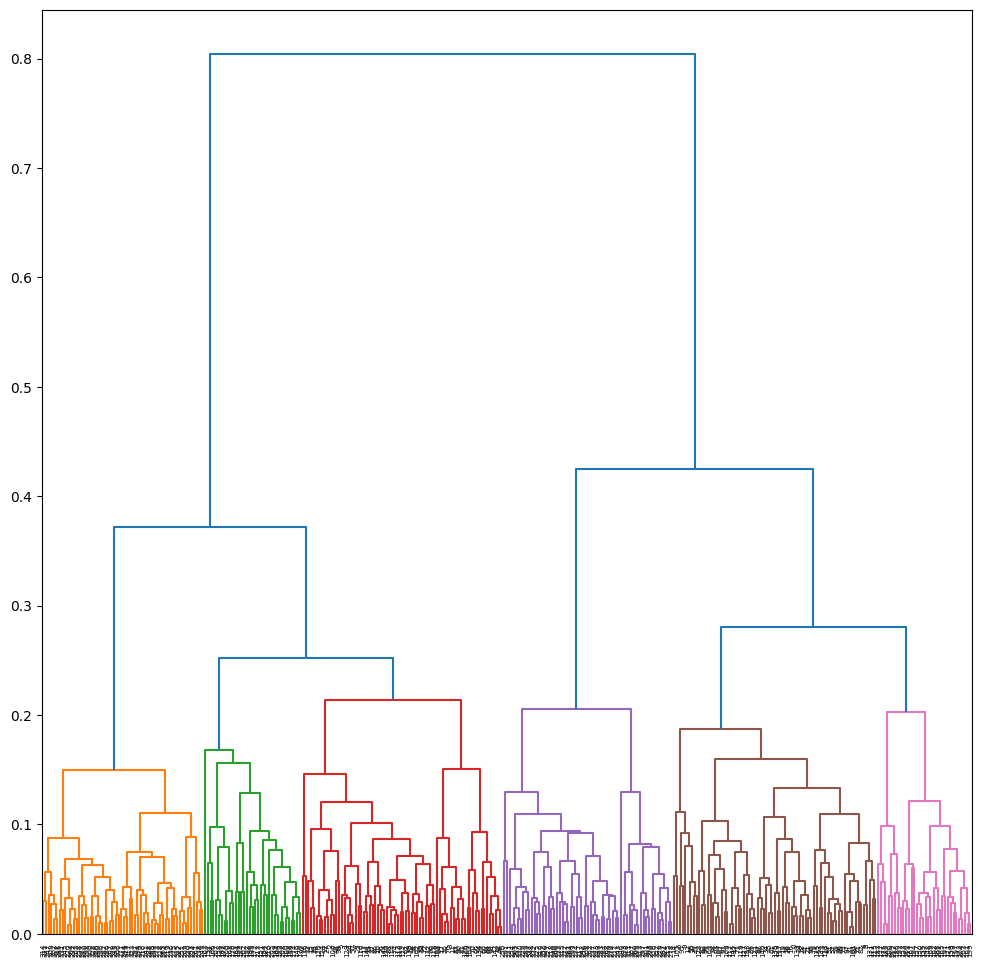

In [16]:
fig,axs = plt.subplots(1,1,figsize=(12,12))
dn = dendrogram(Z, truncate_mode='level',p=30,show_leaf_counts=True,ax=axs, color_threshold=.24)
print(f"Leaves = {len(dn['leaves'])}")

Vamos marcar os grupos na tabela original e fazer uma rápida inspeção para identificar os grupos.

In [17]:
pg2['grupo'] = fcluster(Z, 6, criterion='maxclust')
pg2.grupo.value_counts()

grupo
5    73
3    72
4    61
1    58
2    35
6    34
Name: count, dtype: int64

Vamos fazer uma análise descritiva agora dos grupos, e tentar identificar as características deles quanto a espécie e sexo do pinguim.

In [18]:
pg3 = pg.reset_index().merge(pg2.reset_index(), how='left')
pg3.groupby(['sex', 'species', 'grupo'])['index'].count().unstack().fillna(0).style.format(precision=0)

## Classificando os grupos

É comum, em projetos de agrupamentos, precisarmos de um procedimento que classifica novas observações aos grupos que obtivemos.

No *k-means* podemos adotar um critério de classificação natural utilizando o ```.fit()```, que vai avaliar a distância da nova observação a cada um dos centróides, e classificar naquele grupo que resultar a menor distância. Mas e nos métodos hierárquicos? Você consegue pensar em como classificar novas observações?

Bem, não há um método natural. Mas você pode utilizar todos os algoritmos de classificação que já conhece para fazer a classificação dos métodos hierárquicos, como a regressão logística, árvore de classificação, random forest etc. Pode utilizar as mesmas técnicas de *cross-validation* para garantir a qualidade e tudo. Uma característica é que a acurácia costuma ser bem razoável, pois os grupos procuram ser definidos como função dos dados, o que deve facilitar um pouco as coisas para o algoritmo de classificação.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [20]:
pg3.columns

# selecionar variáveis explicativas (features) e eliminar missings
X = pg3.dropna()[['bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex_Female', 'sex_Male']]

# Selecionar variável resposta (target)
y = pg3.dropna()['grupo']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)

In [22]:
clf = RandomForestClassifier(random_state=2360873, n_estimators=50)

grid_parametros = {'ccp_alpha':np.arange(0, .1, .01)}


In [23]:
np.arange(0, .1, .01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [24]:
grid = GridSearchCV(estimator = clf, param_grid=grid_parametros, cv=4, verbose=100)
grid.fit(X_train, y_train) 

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START ccp_alpha=0.0..............................................
[CV 1/4; 1/10] END ...............ccp_alpha=0.0;, score=0.985 total time=   0.1s
[CV 2/4; 1/10] START ccp_alpha=0.0..............................................
[CV 2/4; 1/10] END ...............ccp_alpha=0.0;, score=0.985 total time=   0.0s
[CV 3/4; 1/10] START ccp_alpha=0.0..............................................
[CV 3/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.0s
[CV 4/4; 1/10] START ccp_alpha=0.0..............................................
[CV 4/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.0s
[CV 1/4; 2/10] START ccp_alpha=0.01.............................................
[CV 1/4; 2/10] END ..............ccp_alpha=0.01;, score=1.000 total time=   0.0s
[CV 2/4; 2/10] START ccp_alpha=0.01.............................................
[CV 2/4; 2/10] END ..............ccp_alpha=0.01;

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=50,
                                              random_state=2360873),
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             verbose=100)

In [25]:
grid.best_params_

{'ccp_alpha': 0.01}

In [26]:
resultados = pd.DataFrame(grid.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.133265,0.050562,0.006636,0.001085,0.0,{'ccp_alpha': 0.0},0.985075,0.985075,1.000000,1.0,0.992537,0.007463,7
1,0.083862,0.005958,0.004449,0.001124,0.01,{'ccp_alpha': 0.01},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
2,0.092914,0.006402,0.005285,0.001147,0.02,{'ccp_alpha': 0.02},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
3,0.087009,0.005913,0.005481,0.001102,0.03,{'ccp_alpha': 0.03},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
4,0.082190,0.003384,0.004853,0.000137,0.04,{'ccp_alpha': 0.04},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
5,0.080941,0.002366,0.004555,0.000848,0.05,{'ccp_alpha': 0.05},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
6,0.078535,0.004856,0.005030,0.000768,0.06,{'ccp_alpha': 0.06},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
7,0.078700,0.005701,0.005301,0.000863,0.07,{'ccp_alpha': 0.07},1.000000,0.985075,0.984848,1.0,0.992481,0.007520,8
8,0.098330,0.018195,0.006200,0.001000,0.08,{'ccp_alpha': 0.08},1.000000,0.985075,0.984848,1.0,0.992481,0.007520,8
9,0.099345,0.008886,0.006482,0.002590,0.09,{'ccp_alpha': 0.09},0.985075,0.985075,0.984848,1.0,0.988749,0.006496,10


In [27]:
clf = RandomForestClassifier(random_state=2360873, n_estimators=50, ccp_alpha=0.01)
clf.fit(X_train,y_train)

RandomForestClassifier(ccp_alpha=0.01, n_estimators=50, random_state=2360873)

In [28]:
clf.score(X_test, y_test)

1.0